In [2]:
import sys
sys.path.append('/workspaces/bha2/src')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import nibabel as nib
from nilearn import plotting
from connectivity_functions import *
from tree_functions import *
from ni_functions import *
from io_functions import load_data, load_receptor_data
import os
import json
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, leaves_list

/opt/conda/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [5]:
project_path = "/workspaces/bha2"
conn_size = 2165

In [6]:
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)

fcm and scm loaded from tmp folder


In [7]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 

print("connectome density = " + str(density))

connectome density = 0.07191603968863612


In [8]:
atlas_name = "craddock_" + str(conn_size) + ".nii.gz"
atlas = nib.load(os.path.join(project_path, "brain_templates", atlas_name))
atlas_vol = atlas.get_fdata()

atlas_nonzero = np.zeros((atlas_vol.shape[0],atlas_vol.shape[1],atlas_vol.shape[2],1))
print(atlas_nonzero.shape)
old_rois = np.arange(1, atlas_vol.max()+1, dtype=int)
old_rois = np.delete(old_rois, zero_rows_sc)
old_rois = np.delete(old_rois, zero_rows_fc)

for idx, rois in enumerate(old_rois):
    atlas_nonzero[atlas_vol == rois] = idx+1

atlas_nonzero_img = nib.Nifti1Image(atlas_nonzero, affine=atlas.affine)

(91, 109, 91, 1)


In [36]:
tree_min = 2
tree_max = 200

g=0.8
opt_level=47
W = matrix_fusion(g, fcm_bin, scm_bin)
t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")

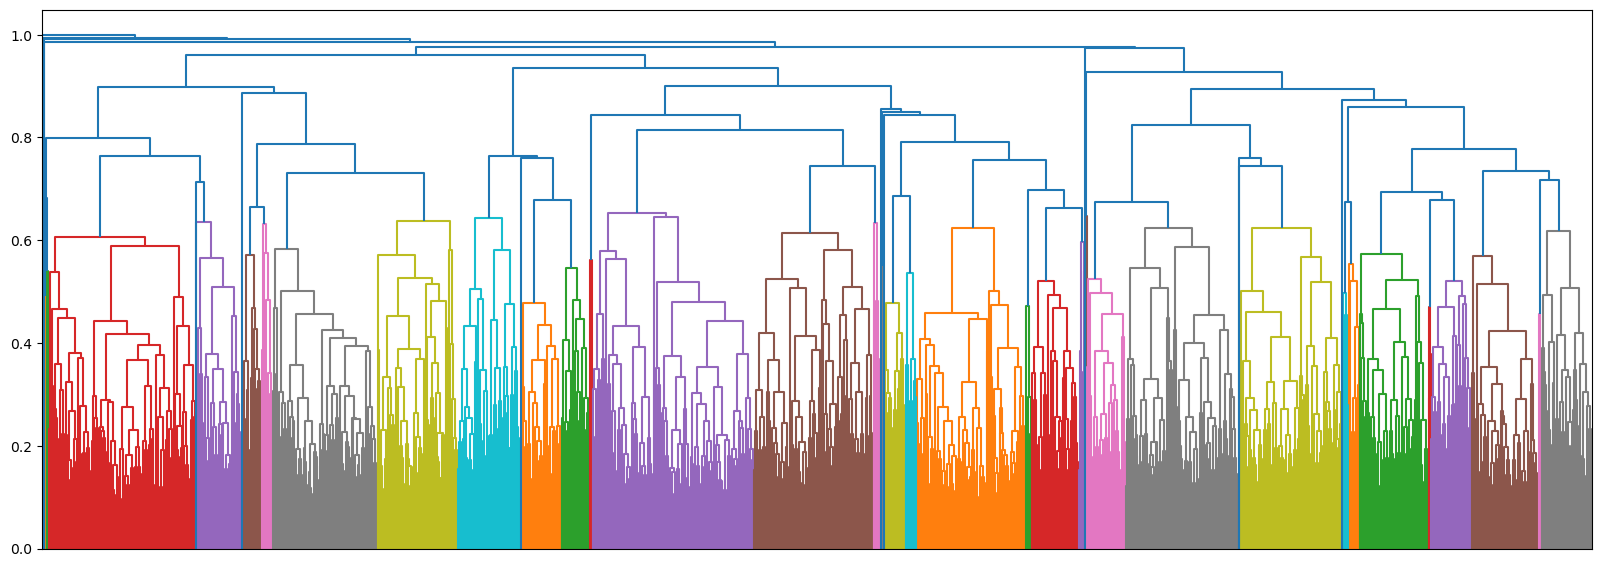

In [21]:
plt.rcParams['figure.figsize'] = [20, 7]

Z = linkage(W, "average")
height_in_tree_sorted = Z[:,2][::-1]

den = dendrogram(Z, color_threshold=height_in_tree_sorted[opt_level-2], no_labels=True)

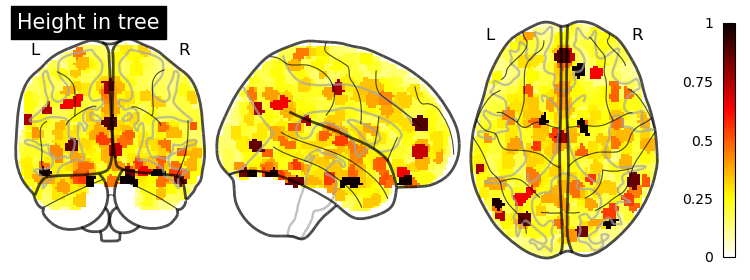

In [22]:
roi_break_heights = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
leaves_first_list_sorted = Z[:,0][::-1].astype(int)
leaves_second_list_sorted = Z[:,1][::-1].astype(int)

for roi in range(fcm_bin.shape[1]):
    idx_in_first_list = np.where(leaves_first_list_sorted == roi)[0]
    idx_in_second_list = np.where(leaves_second_list_sorted == roi)[0]
    if idx_in_first_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(atlas_nonzero_img, roi, height_in_tree_sorted[idx_in_first_list[0]])
    elif idx_in_second_list.size > 0:
        roi_break_heights = roi_break_heights + get_module_vol(atlas_nonzero_img, roi, height_in_tree_sorted[idx_in_second_list[0]])
    else:
        print("roi " + str(roi) + " not found")

plotting.plot_glass_brain(nib.Nifti1Image(roi_break_heights, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Height in tree")
nib.save(nib.Nifti1Image(roi_break_heights, affine=atlas_nonzero_img.affine),  os.path.join(project_path, "data", "results", "n" + str(conn_size), "roi_breaks_heights.nii.gz"))

In [ ]:
leaves = leaves_list(Z)
height_in_tree_nosorted = np.hstack((1,Z[:,2]))
module_selected = 47
module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_selected)]

W_mod = matrix_fusion(g, fcm_bin[module_rois,:], scm_bin[module_rois,:])
Z_mod = linkage(W_mod, "average")
height_in_tree_sorted_mod = Z_mod[:,2][::-1]

# Plot the new dendrogram
den_mod = dendrogram(Z_mod,  color_threshold=1)
len(den_mod['leaves'])

Text(0, 0.5, 'Module duration')

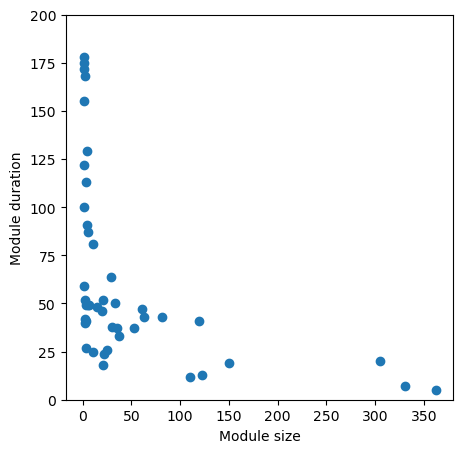

In [37]:
plt.rcParams['figure.figsize'] = [5, 5]

module_duration = []
module_size = []

for module_indices in range(1,opt_level+1):
        module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
        module_presence_in_tree = []
        for l in range(2,200):
                        level, labels = level_from_tree(t_dict, l)
                        for module in level:
                                if module == module_rois:
                                        module_presence_in_tree.append(l)
                                        break
        if len(module_rois) > 1:
                module_duration.append(len(module_presence_in_tree))
                module_size.append(len(module_rois))
        else:
                module_duration.append(1584) #sustituir el hardcodeo
                module_size.append(1)

plt.scatter(module_size, module_duration)
plt.ylim(0, 200)
plt.xlabel("Module size")
plt.ylabel("Module duration")

Text(0, 0.5, 'Module duration')

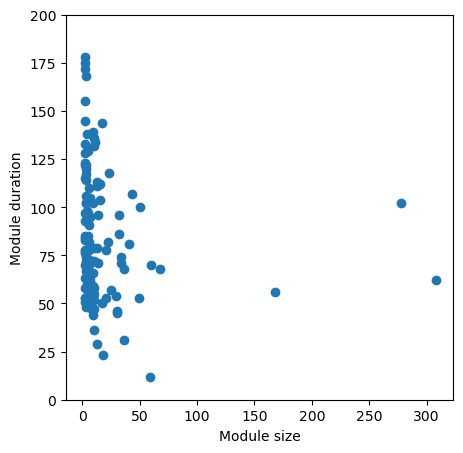

In [38]:
plt.rcParams['figure.figsize'] = [5, 5]

module_duration = []
module_size = []
opt_level = 150
for module_indices in range(1,opt_level+1):
        module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
        module_presence_in_tree = []
        for l in range(2,200):
                        level, labels = level_from_tree(t_dict, l)
                        for module in level:
                                if module == module_rois:
                                        module_presence_in_tree.append(l)
                                        break
        if len(module_rois) > 1:
                module_duration.append(len(module_presence_in_tree))
                module_size.append(len(module_rois))
        else:
                module_duration.append(1584) #sustituir el hardcodeo
                module_size.append(1)

plt.scatter(module_size, module_duration)
plt.ylim(0, 200)
plt.xlabel("Module size")
plt.ylabel("Module duration")

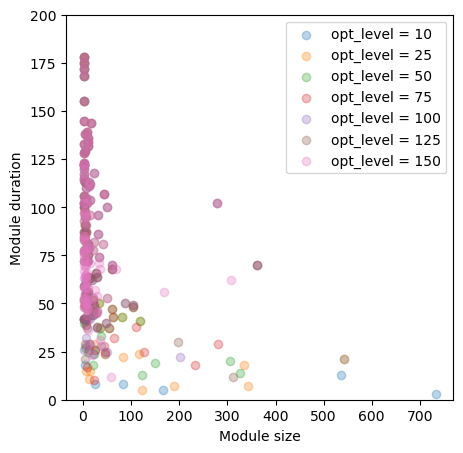

In [35]:
tree_min = 2
tree_max = 200

for opt_level in [10, 25, 50, 75, 100, 125, 150]:
    g=0.8
    W = matrix_fusion(round(g,2), fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    module_duration = []
    module_size = []

    for module_indices in range(1,opt_level+1):
            module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
            module_presence_in_tree = []
            for l in range(2,200):
                            level, labels = level_from_tree(t_dict, l)
                            for module in level:
                                    if module == module_rois:
                                            module_presence_in_tree.append(l)
                                            break
            if len(module_rois) > 1:
                    module_duration.append(len(module_presence_in_tree))
                    module_size.append(len(module_rois))
            else:
                    module_duration.append(2165) #sustituir el hardcodeo
                    module_size.append(1)
    plt.scatter(module_size, module_duration, alpha=0.3, label = "opt_level = " + str(opt_level))
    plt.ylim(0, 200)
    plt.xlabel("Module size")
    plt.ylabel("Module duration")
    plt.legend()

/workspaces/bha2/src/tree_functions.py:23: UserWarning: Empty cluster found in level 2, module 2!
  warnings.warn("Empty cluster found in level " + str(lvl) + ', module ' + str(i) + "!")
/workspaces/bha2/src/tree_functions.py:23: UserWarning: Empty cluster found in level 151, module 151!
  warnings.warn("Empty cluster found in level " + str(lvl) + ', module ' + str(i) + "!")
/workspaces/bha2/src/tree_functions.py:23: UserWarning: Empty cluster found in level 169, module 169!
  warnings.warn("Empty cluster found in level " + str(lvl) + ', module ' + str(i) + "!")


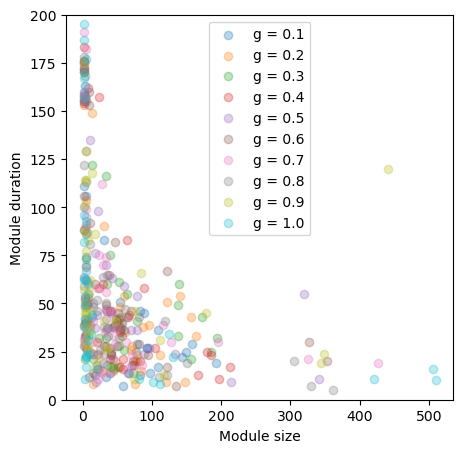

In [30]:
tree_min = 2
tree_max = 200

for g in np.arange(0.1, 1.1, 0.1):
    opt_level=47
    W = matrix_fusion(round(g,2), fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    module_duration = []
    module_size = []

    for module_indices in range(1,opt_level+1):
            module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
            module_presence_in_tree = []
            for l in range(2,200):
                            level, labels = level_from_tree(t_dict, l)
                            for module in level:
                                    if module == module_rois:
                                            module_presence_in_tree.append(l)
                                            break
            if len(module_rois) > 1:
                    module_duration.append(len(module_presence_in_tree))
                    module_size.append(len(module_rois))
            else:
                    module_duration.append(2165) #sustituir el hardcodeo
                    module_size.append(1)
    plt.scatter(module_size, module_duration, alpha=0.3, label = "g = " + str(round(g,2)))
    plt.ylim(0, 200)
    plt.xlabel("Module size")
    plt.ylabel("Module duration")
    plt.legend()

Text(0, 0.5, 'Module heights')

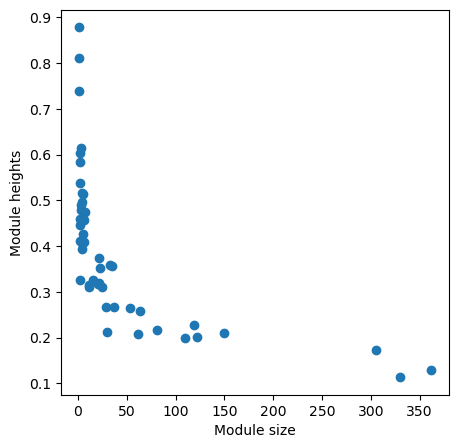

In [40]:
module_heights = []
module_size = []
for module_indices in range(1,opt_level+1):
        module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
        module_size.append(len(module_rois))
        heights_from_first_list = height_in_tree_sorted[np.where(np.in1d(leaves_first_list_sorted, module_rois))[0]]
        heights_from_second_list = height_in_tree_sorted[np.where(np.in1d(leaves_second_list_sorted, module_rois))[0]]
        module_heights.append(np.mean(np.hstack((heights_from_first_list, heights_from_second_list))))

plt.scatter(module_size, module_heights)
plt.xlabel("Module size")
plt.ylabel("Module heights")

Text(0, 0.5, 'Module heights')

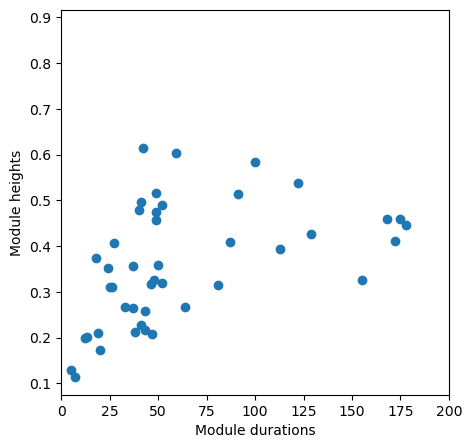

In [41]:
plt.scatter(module_duration, module_heights)
plt.xlim(0, 200)
plt.xlabel("Module durations")
plt.ylabel("Module heights")

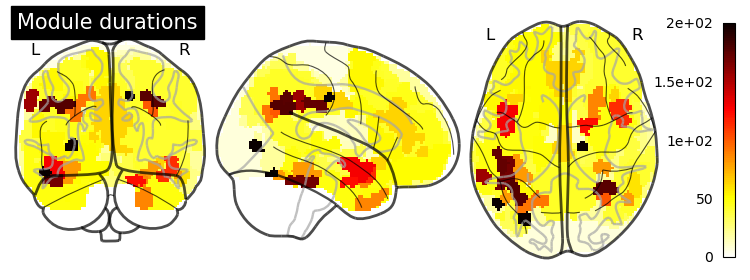

In [42]:
module_durations = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
    module_durations = module_durations + get_module_vol(atlas_nonzero_img, module_rois, module_duration[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_durations, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module durations", vmax=200)

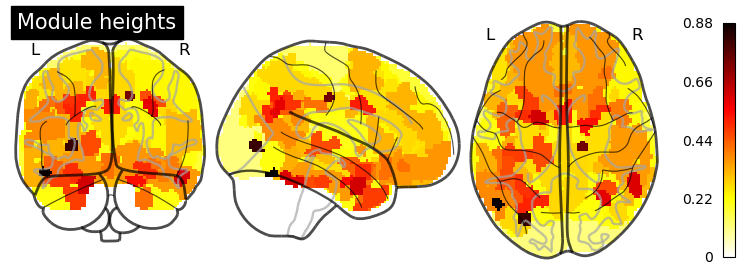

In [43]:
module_heights_img = np.zeros((atlas_nonzero_img.shape[0],atlas_nonzero_img.shape[1],atlas_nonzero_img.shape[2]))
for idx,module_indices in enumerate(range(1,opt_level+1)):
    module_rois = t_dict['lvl_' + str(opt_level) + '_mod_' + str(module_indices)]
    module_heights_img = module_heights_img + get_module_vol(atlas_nonzero_img, module_rois, module_heights[idx])
plotting.plot_glass_brain(nib.Nifti1Image(module_heights_img, affine=atlas_nonzero_img.affine), 
        colorbar=True, title="Module heights")